### Notes:

* jupyter notebook shows visualizations of the results from solidity implementation, cadCAD model, kovan and error metrics

In [1]:
from pathlib import Path
from decimal import Decimal
import datetime
import os
import csv
import sys
import datetime as dt
import json
from enum import Enum
import pandas as pd
import numpy as np
%matplotlib inline

sys.path.append('./models')

path = Path().resolve()
root_path = str(path).split('notebooks')[0]
os.chdir(root_path)

In [2]:
# history of PIRateSetter UpdateRedemptionRate Events pulled from kovan archive node
events = pd.read_csv('./tests/data/updateredemptionrate.csv.gz').iloc[:]
events['ts_delta'] = events['ts'].diff()

In [3]:
events.head(3)

,marketPrice,redemptionPrice,redemptionRate,transactionHash,address,blockNumber,ts,ts_delta
0,5158634825269270578000000000,3069049498519715117488353819,999999998955207336625222270,0x16601870b8c4dc9e63baf0d07d810ec26d61c04844fe...,0x97533CD0c5997bce2504378CB29a091830de0F94,29727211,1644351052,NaN
1,5119936915872816092000000000,3068977352658686529626576365,999999846178032758940282822,0x78d5a7892e2418f786e70b0a55ad6f9b37c8f9b7abbc...,0x97533CD0c5997bce2504378CB29a091830de0F94,29732208,1644373552,22500.0
2,5102952610086358532000000000,3058373998490887100392595607,999999845629135990734283981,0xf5ca0453140ce69bbf74bf09b052abda208835f04844...,0x97533CD0c5997bce2504378CB29a091830de0F94,29737038,1644396052,22500.0


In [4]:
# Convert integers(RAY) to decimals
events['redemptionRateDec'] = (events['redemptionRate']).apply(lambda x: Decimal(x)/Decimal(1e27)) - 1
events['redemptionPriceDec'] = (events['redemptionPrice']).apply(lambda x: Decimal(x)/Decimal(1e27))

In [5]:
market_prices = events['marketPrice'].iloc[1:].apply(lambda x: float(x)/1E27)#.reset_index(drop=True)
delta_t = events['ts_delta'].iloc[1:]#.reset_index(drop=True)

In [6]:
Kp = 7.5e-8
Ki = 2.23E-14

#per_second_leak = 1000000000000000000000000000 # no leak
per_second_leak = 999999711200000000000000000

SIMULATION_TIMESTEPS = len(market_prices) - 1

save_dir = "../truffle/test/saved_sims/pi_second/raw/custom-config-sim.txt"

config_file = {
  "Kp": str(int(Kp * 1e18)),
  "Ki": str(int(Ki * 1e18)),
  "noise_barrier": "1000000000000000000",
  "per_second_leak": str(int(per_second_leak)),
  "oracle_initial_price": str(events['marketPrice'].iloc[1]),
  "initial_redemption_price": str(events['redemptionPrice'].iloc[1]),
  "delta_t": [str(i) for i in delta_t],
  "market_prices": [str(int(i*1e18)) for i in market_prices],
  "save_dir": save_dir
}

with open('./cross-model/truffle/test/config/pi_second_raw.json', 'w') as fp:
    json.dump(config_file, fp)
    
config_file = {
  "alpha": per_second_leak,
  "kp": Kp,
  "ki": lambda control_period=0: Ki, # v1 model adjusts by control period, but solidity/prod doesn't do this
  "delta_t": delta_t,
  "target_rate": float(Decimal(events['redemptionRate'].iloc[0])/Decimal(1e27)),
  "target_price": float(events['redemptionPrice'].iloc[0])/1e27,
  "market_price": float(events['marketPrice'].iloc[0])/1e27,
  "market_prices": market_prices,
}

In [7]:
# Compile, test, and deploy contracts to Ganache
# !npm run pi-raw-second-imported-config --prefix './cross-model/truffle'

os.chdir('./cross-model/truffle')
!npm run install-deps
!npm run pi-raw-second-imported-config
os.chdir('../../')


> geb-rrfm-truffle-sims@1.0.0 install-deps
> npm install

m#########⠂⠂⠂⠂⠂⠂⠂⠂⠂⸩ ⠙ idealTree: timing idealTree Completed in 12ms
up to date, audited 3 packages in 601ms

found 0 vulnerabilities

> geb-rrfm-truffle-sims@1.0.0 pi-raw-second-imported-config
> npx truffle test test/pi_raw_second_imported_config.js


Compiling your contracts...
> Compiling ./cross-model/truffle/contracts/Migrations.sol
> Compiling ./cross-model/truffle/contracts/calculator/math/SafeMath.sol
> Compiling ./cross-model/truffle/contracts/calculator/math/SignedSafeMath.sol
> Compiling ./cross-model/truffle/contracts/calculator/per-second/raw/PIRawPerSecondValidator.sol
> Compiling ./cross-model/truffle/contracts/calculator/per-second/scaled/PIScaledPerSecondValidator.sol
> Compiling ./cross-model/truffle/contracts/mock/AGUpdater.sol
> Compiling ./cross-model/truffle/contracts/mock/MockOracleRelayer.sol
> Compiling ./cross-model/truffle/contracts/mock/MockTreasury.sol
> Compiling ./cross-model/truffle/contracts/mo

[redemptionRate](https://github.com/reflexer-labs/geb-rrfm-truffle-sims/blob/master/contracts/mock/MockOracleRelayer.sol#L14) = $1+d_t$ (units: per second)  
$p_{t+\Delta{t}} = p_{t} (1+d_t)^{\Delta{t}}$ where $\Delta{t}$ is measured in seconds  
Meaning:
* $d_t > 0$ implies $redemptionRate > 1$  
* $d_t < 0$ implies $redemptionRate < 1$  


In the results dataset this is the PerSecondRedemptionRate column

In [8]:
from models.system_model_v1.model.state_variables.init import state_variables

def pre_process_initial_conditions(genesis_dict):
    base_genesis_states = genesis_dict.copy()
    for k in base_genesis_states.keys():
        if k in config_file:
            try:
                base_genesis_states[k] = config_file[k][0]
            except:
                base_genesis_states[k] = config_file[k]
    return base_genesis_states

test_specific_initial_conditions = pre_process_initial_conditions(state_variables)

In [9]:
from models.system_model_v1.model.params.init import params


def pre_process_params_dict(params_dict):
    base_params_dict = params_dict.copy()
    for k in config_file.keys():
        if type(config_file[k]) == list:
            base_params_dict[k] = [config_file[k]]
        else:
            try:
                base_params_dict[k] = [config_file[k]]
            except OverflowError:
                print(config_file[k])
                raise
    return base_params_dict

test_specific_params = pre_process_params_dict(params)

In [10]:
def test_specific_resolve_time_passed(params, substep, state_history, state):
    index = state['timestep']+1
    value = params['delta_t'][index]
    return {'seconds_passed': value}

def test_specific_update_market_price(params, substep, state_history, state, policy_input):
    key = 'market_price'  
    index = state['timestep']
    value = params['market_prices'][index]
    return key, value


from models.system_model_v1.model.parts.markets import resolve_time_passed, update_market_price
from models.system_model_v1.model.partial_state_update_blocks import partial_state_update_blocks

for psub in partial_state_update_blocks:
    for psub_part in psub.values():
        if type(psub_part)==dict:
            for k,v in psub_part.items():
                if v == resolve_time_passed:
                    psub_part[k] = test_specific_resolve_time_passed
                if v == update_market_price:
                    psub_part[k] = test_specific_update_market_price

In [11]:
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD import configs

del configs[:]

exp = Experiment()

sim_config_dict = {
    'T': range(SIMULATION_TIMESTEPS),
    'N': 1,
    'M': test_specific_params
}
c = config_sim(sim_config_dict)

exp.append_configs(
    initial_state=test_specific_initial_conditions, #dict containing variable names and initial values
    partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
    sim_configs=c #preprocessed dictionaries containing simulation parameters
)

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(exec_mode.local_mode)
executor = Executor(local_mode_ctx, configs) # Pass the configuration object inside an array
raw_result, tensor, sessions = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (36, 27, 1, 15)



Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded



Total execution time: 0.11s


In [12]:
full = pd.DataFrame(raw_result)

In [13]:
max_substep = max(full.substep)
df = full.copy()
df = df[(df.substep==max_substep) | (df.substep==0)]

In [14]:
save_dir = "./cross-model/truffle/test/saved_sims/pi_second/raw/custom-config-sim.txt"
data = pd.read_csv(save_dir, sep=" ", header=None, skiprows=1)
data.columns = [x.replace(' ','') for x in pd.read_csv(save_dir, sep="|", nrows=1).columns]

#for c in data.columns:
#    data[c]=data[c].apply(float)
    
#define normalizing constants
WAD = 10**18
RAY = 10**27
RAD = 10**45

#normalize data to "USD" dimension
data['MarketPrice(USD)'] = data['MarketPrice(WAD)']/WAD
data['RedemptionPrice(USD)'] = data['RedemptionPrice(RAY)'].apply(lambda x: float(x))/RAY
data['PerSecondRedemptionRate(float)'] = data['PerSecondRedemptionRate(RAY)'].apply(lambda x: float(x))/RAY - 1
data['PerSecondRedemptionRate(dec)'] = data['PerSecondRedemptionRate(RAY)'].apply(lambda x: Decimal(x)/Decimal(1e27)) - 1
data['time'] = data['DelaySinceLastUpdate'].cumsum()

data['timestamp'] = state_variables['timestamp'] + data['time'].apply(lambda x: dt.timedelta(seconds=x))

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   MarketPrice(WAD)                 37 non-null     int64         
 1   RedemptionPrice(RAY)             37 non-null     object        
 2   RedemptionRate(%)                37 non-null     int64         
 3   PerSecondRedemptionRate(RAY)     37 non-null     object        
 4   RedemptionRateTimeline(Seconds)  37 non-null     int64         
 5   Proportional(NoGain)             37 non-null     object        
 6   Proportional(WithGain)           37 non-null     object        
 7   Integral(NoGain)                 37 non-null     object        
 8   Integral(WithGain)               37 non-null     int64         
 9   DelaySinceLastUpdate             37 non-null     float64       
 10  MarketPrice(USD)                 37 non-null     float64       


In [16]:
#df[['target_price', 'market_price']] = df[['target_price', 'market_price']].shift()

In [17]:
combined = df.merge(data, how='inner', on=['timestamp'])

In [18]:
events['timestamp'] = pd.to_datetime(events['ts'], unit='s')

In [19]:
events[['timestamp', 'marketPrice', 'redemptionPrice', 'redemptionRate', 'blockNumber', 'ts_delta']].head(3)

,timestamp,marketPrice,redemptionPrice,redemptionRate,blockNumber,ts_delta
0,2022-02-08 20:10:52,5158634825269270578000000000,3069049498519715117488353819,999999998955207336625222270,29727211,NaN
1,2022-02-09 02:25:52,5119936915872816092000000000,3068977352658686529626576365,999999846178032758940282822,29732208,22500.0
2,2022-02-09 08:40:52,5102952610086358532000000000,3058373998490887100392595607,999999845629135990734283981,29737038,22500.0


In [20]:
data[['MarketPrice(WAD)' ,'RedemptionPrice(RAY)', 'PerSecondRedemptionRate(RAY)']].head(3)

,MarketPrice(WAD),RedemptionPrice(RAY),PerSecondRedemptionRate(RAY)
0,5119936915872816128,3068977352658686529626576365,999999846178032758940280122
1,5102952610086358016,3058373998490887100206800723,999999845629135990734322788
2,5160239309718213632,3047769163934361049993803401,999999839500980558759762286


In [21]:
df[['timestamp', 'target_price']].head(3)

,timestamp,target_price
0,2018-12-18 00:00:00,3.069049
6,2018-12-18 06:15:00,3.058210
12,2018-12-18 12:30:00,3.047482


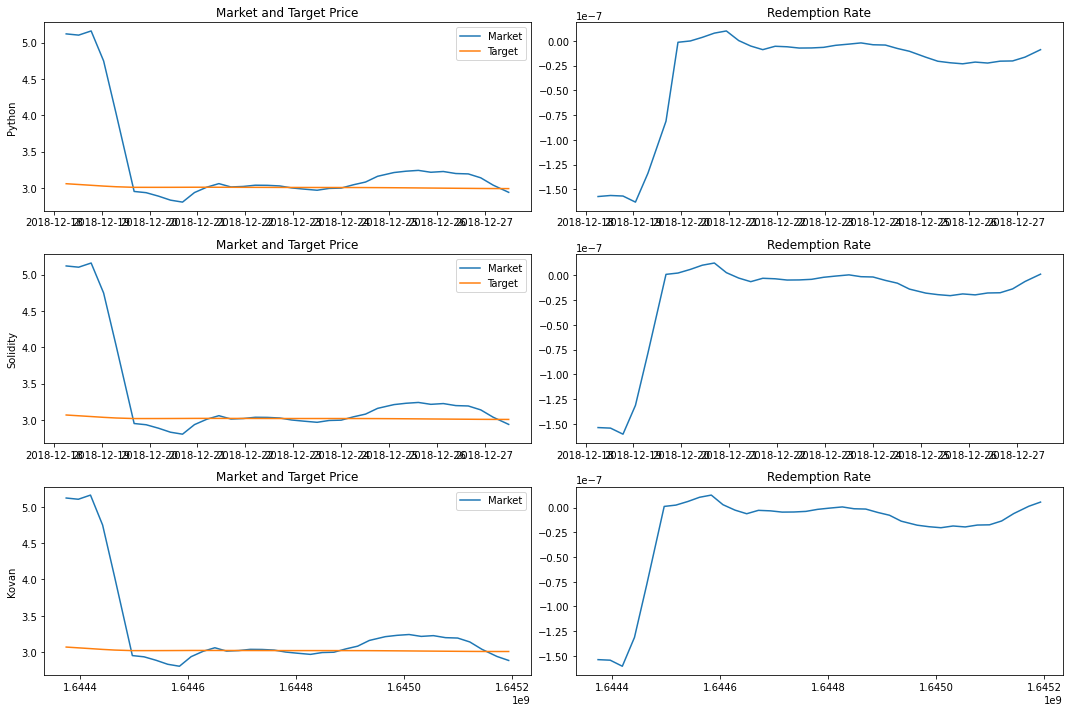

In [22]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 2, figsize=(15,10))

i = 0
axs.flat[i].plot(combined['timestamp'], combined['market_price'], label='Market')
axs.flat[i].plot(combined['timestamp'], combined['target_price'], label='Target')
axs.flat[i].set_ylabel('Python')
axs.flat[i].set_title('Market and Target Price')
axs.flat[i].legend()

i += 1 
axs.flat[i].plot(combined['timestamp'], combined['target_rate'])
axs.flat[i].set_title('Redemption Rate')

i += 1 
axs.flat[i].plot(combined['timestamp'], combined['MarketPrice(USD)'], label='Market')
axs.flat[i].plot(combined['timestamp'], combined['RedemptionPrice(USD)'], label='Target')
axs.flat[i].set_title('Market and Target Price')
axs.flat[i].legend()
axs.flat[i].set_ylabel('Solidity')

i += 1 
axs.flat[i].plot(combined['timestamp'], combined['PerSecondRedemptionRate(dec)'])
axs.flat[i].set_title('Redemption Rate')

i += 1
axs.flat[i].plot(events['ts'].iloc[1:], events['marketPrice'].iloc[1:].apply(lambda x: float(x)/1E27), label='Market')

axs.flat[i].plot(events['ts'].iloc[1:], events['redemptionPriceDec'].iloc[1:])
axs.flat[i].set_ylabel('Kovan')
axs.flat[i].set_title('Market and Target Price')
axs.flat[i].legend()

i += 1 

axs.flat[i].plot(events['ts'].iloc[1:], events['redemptionRateDec'].iloc[1:])
axs.flat[i].set_title('Redemption Rate')

fig.tight_layout()
plt.show()
fig.savefig('plots/solidity-cadcad/solidity-cadcad-market.png')

## Solidity-Python Error 

<AxesSubplot:>

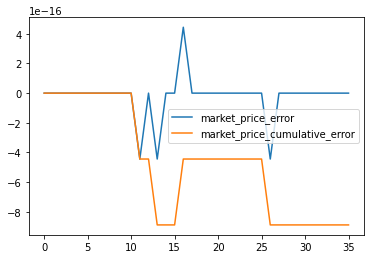

In [23]:
combined['market_price_error'] = combined['market_price'] - combined['MarketPrice(USD)']
combined['market_price_error'].plot(legend=True)
combined['market_price_cumulative_error'] = combined['market_price_error'].cumsum()
combined['market_price_cumulative_error'].plot(legend=True)

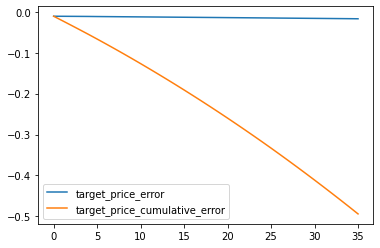

In [24]:
combined['target_price_error'] = combined['target_price'] - combined['RedemptionPrice(USD)']
combined['target_price_error'].plot(legend=True)
combined['target_price_cumulative_error'] = combined['target_price_error'].cumsum()
combined['target_price_cumulative_error'].plot(legend=True)
plt.savefig('plots/solidity-cadcad/solidity-cadcad-error.png')

In [25]:
print(f'''
Max error: {combined['target_price_error'].max()}
Std. error: {combined['target_price_error'].std()}
Mean error: {combined['target_price_error'].mean()}
Abs. mean error: {combined['target_price_error'].abs().mean()}
''')


Max error: -0.010766875574300894
Std. error: 0.0018847603245201528
Mean error: -0.013726906535381864
Abs. mean error: 0.013726906535381864



In [26]:
combined['target_price_cumulative_error'].describe()

count     36.000000
unique    36.000000
top       -0.494169
freq       1.000000
Name: target_price_cumulative_error, dtype: float64

## Solidity-Kovan Error

<AxesSubplot:>

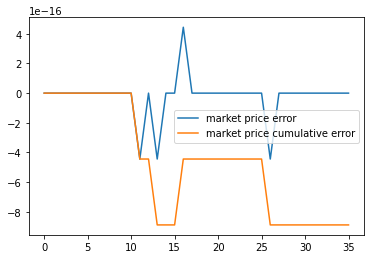

In [27]:
(events['marketPrice'].iloc[1:].apply(lambda x: float(x)/1E27).reset_index(drop=True) - combined['MarketPrice(USD)']).plot(legend=True, label='market price error')
(events['marketPrice'].iloc[1:].apply(lambda x: float(x)/1E27).reset_index(drop=True)- combined['MarketPrice(USD)']).cumsum().plot(legend=True, label='market price cumulative error')

<AxesSubplot:>

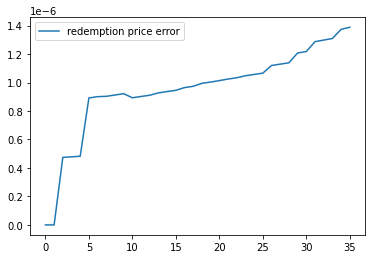

In [31]:
(events['redemptionPrice'].apply(lambda x: int(x)).iloc[1:].reset_index(drop=True) - \
  combined['RedemptionPrice(RAY)'].apply(lambda x: int(x)).iloc[0:])\
  .apply(lambda x:float(x)/1e27)\
  .plot(legend=True, label='redemption price error')

The above redemption price error when comparing to kovan is due to intermediate redemption price updates on Kovan.  This data is dervied from UpdateRedemptionRate events only, so does not conside these intermediate updates.  The Redemption price is necessarily rounded as it's a RAY created from a RAD rate. So these intermediate price updates onchain produce very neglible differences from redemption prices created only from UpdateRedemptionRate events.

<AxesSubplot:>

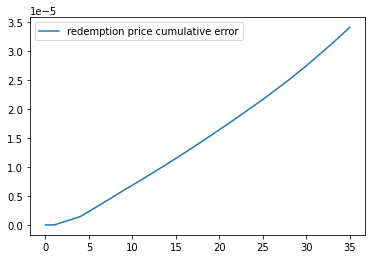

In [32]:

(events['redemptionPrice'].apply(lambda x: int(x)).iloc[1:].reset_index(drop=True) - \
 combined['RedemptionPrice(RAY)'].apply(lambda x: int(x)))\
  .apply(lambda x:float(x)/1e27) \
  .cumsum() \
  .plot(legend=True, label='redemption price cumulative error')